This notebook is intended to explore how to read and store the data and what is the most confortable way to work with our dataset.

### Reading the data

In [2]:
# imports
import sys

import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# make sure you are working on an appropiate environment
print(sys.executable)

c:\Users\aitor\.conda\envs\ml_course\python.exe


In [23]:
# accessing the videos
VID_NUM = 3
path = '../data/pw1_A1_0315_part' + str(VID_NUM) + '.avi'
vid = cv2.VideoCapture(path)

In [24]:
# calculating global constants 
N_FRAMES = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
vid.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = vid.read()
frame = frame[:,:,0]
N, M = frame.shape

In [5]:
# sets to 0 the borders of a one channel frame. 
# The width of the border is specified by n_pixels
def remove_borders(frame, n_pixels=0):
    frame[0:n_pixels, :] = frame[N-n_pixels:, :] = frame[:, 0:n_pixels] = frame[:, M-n_pixels:] = 0
    return frame

In [33]:
def remove_outside_petri(frame, center, radius_i, radius_j):
    I, J = np.ogrid[:N, :M]
    dist_from_center = ((I - center[0])/radius_i)**2 + ((J-center[1])/radius_j)**2
    mask = dist_from_center <= 1
    frame[~mask] = 0
    # plt.imshow(frame, cmap='gray')
    return frame

# remove_outside_petri(get_frame(vid, 0), [N//2,M//2 + 0], 325, 325)

In [30]:
def get_frame(vid, frame_id):
    vid.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    ret, frame = vid.read()
    assert(ret==True)
    frame = frame[:,:,0]
    # frame = remove_borders(frame)
    remove_outside_petri(frame, [N//2, M//2 + 0], 325, 325)
    return frame


In [8]:
def get_next_frame(vid):
    ret, frame = vid.read()
    assert(ret==True)
    frame = frame[:,:,0]
    # frame = remove_borders(frame)
    remove_outside_petri(frame, [N//2, M//2 + 0], 325, 325)
    return frame

In [9]:
def print_frame(frame, true_pos=None, estimated_pos=None):
    if true_pos == None or estimated_pos == None:
        plt.imshow(frame, cmap='gray')
        return
    frame_c = np.zeros([N,M,3])
    frame_c[:,:,0] = frame/255
    frame_c[:,:,1] = frame/255
    frame_c[:,:,2] = frame/255

    t1, t2 = int(true_pos[0]), int(true_pos[1])
    e1, e2 = int(estimated_pos[0]), int(estimated_pos[1])

    frame_c[t1-2:t1+2, t2-2:t2+2] = np.array([0, 1, 0])
    frame_c[e1-2:e1+2, e2-2:e2+2] = np.array([1, 0, 0])
    plt.imshow(frame_c, cmap='viridis')

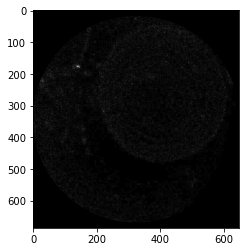

In [10]:
# comparing two frames
f1 = get_frame(vid, 0)
f2 = get_frame(vid, 7)
n, m = f1.shape
plt.imshow(np.abs(f1), cmap='gray', vmin=0, vmax=255)
plt.imshow(cv2.absdiff(f1,f2), cmap='gray')

In [11]:
# mean of frames
def mean_frame(vid, first_frame_id: int, n_frames: int):
    frame = get_frame(vid, first_frame_id)
    mean = np.zeros(frame.shape, dtype=int)
    for i in range(n_frames):
        frame = get_next_frame(vid)
        mean += frame
    mean = mean / n_frames
    return mean.astype(np.uint8)

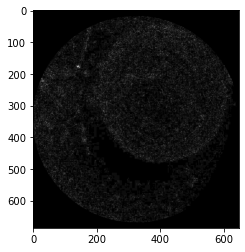

In [12]:
# comparing the mean of some consecutive frames with one frame
mn = mean_frame(vid, 0, 10)
f0 = get_frame(vid, 0)
plt.imshow(cv2.absdiff(mn, f0), cmap='gray')

10


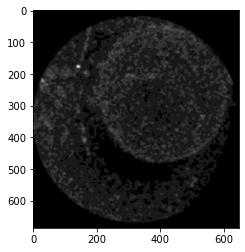

In [13]:
# Convolute with lowpass filter
# Blurs an image using the normalized box filter
kernel_size = (7,7)
blurred_f0_mov = cv2.blur(cv2.absdiff(mn, f0), kernel_size)
plt.imshow(blurred_f0_mov, cmap='gray')
print(np.max(blurred_f0_mov))

In [14]:
indmax = np.argmax(blurred_f0_mov)
print(indmax)
i_max = indmax // M
j_max = indmax % M
print(i_max, j_max, blurred_f0_mov[i_max, j_max])

114837
177 141 10


In [15]:
# get labels from .txt file
# input: path of the file
# output: dictionary where key = slice number, value = true (i, j) coordinates of the worm

def get_labels(path):
    file = open(path, 'r')
    lines = file.readlines()
    slice = 0
    ret = {}
    for i, line in enumerate(lines):
        fields = line.split()
        if i == 0 or fields[7] == slice:
            continue
        true_i = float(fields[6])
        true_j = float(fields[5])
        slice = int(fields[7])
        ret[slice] = (true_i, true_j)
    return ret

labels = get_labels('../data/pw1_A1_0315_part1.txt')
print(labels[345])

(178.5, 143.375)


In [67]:
# hyperparameter R: 
# we don't search outside the ball of radius R (with norm $\ell ^ \infty$) 
# with center at the previous estimate  
def get_position_estimate(frame, background, prev_estimate=None, R=20):
    blurred_f0_mov = cv2.blur(cv2.absdiff(background, frame), kernel_size) #idea: instead of absdiff, do max(0, f0-mn), as the worm is bright
    if prev_estimate != None:
        i_min = max(0, prev_estimate[0] - R)
        i_max = min(N, prev_estimate[0] + R)
        j_min = max(0, prev_estimate[1] - R)
        j_max = min(M, prev_estimate[1] + R)
        # print(i_min, i_max, j_min, j_max)
        blurred_f0_mov[0:i_min, :] = blurred_f0_mov[i_max:, :] = blurred_f0_mov[:, 0:j_min] = blurred_f0_mov[:, j_max:] = 0

    # plt.imshow(blurred_f0_mov, cmap='gray')
    indmax = np.argmax(blurred_f0_mov)
    i_hat = indmax // M
    j_hat = indmax % M
    return i_hat, j_hat

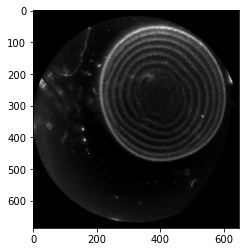

In [68]:
# main framework

avg_window = 20
half_window = (avg_window - 1) // 2
kernel_size = (7,7) # for the lowpass filter

# fill queue
q = []
q.append(get_frame(vid, 0))
for _ in range(avg_window-1):
    q.append(get_next_frame(vid))

pos_hat = {}
# first estimate
mn = mean_frame(vid, 0, avg_window)
f0 = get_frame(vid, half_window)
prev_pos = get_position_estimate(f0, mn)
pos_hat[half_window] = prev_pos

f = open('../out/naive_output.txt', 'w')
for t in range(half_window, N_FRAMES - half_window - 1):
    right_frame = get_next_frame(vid)
    mn = (mn.astype(int) + (right_frame.astype(int) - q.pop(0).astype(int)) / avg_window).astype(np.uint8) # update mean
    q.append(right_frame)
    pos_hat[t] = get_position_estimate(q[half_window], mn, prev_pos)
    prev_pos = pos_hat[t]
    print('Slice:', t, '\tTrue pos:', labels[t] if t in labels else '(???, ???)', '\tEstimated pos:', pos_hat[t], file=f)
f.close()

In [18]:
# Create a metric to evaluate our results

def ell_inf_dist(p1, p2):
    return max(np.abs(p1[0] - p2[0]), np.abs(p1[1] - p2[1]))

''' Calculates a custom accuracy, using ell infinity norm. 
For each frame, if estimated pos and labels are closer than distance small_radix,
we get a score of 1. Else if it's closer than big_radix, we get a score of 0.5. 
Otherwise, 0. Then, the accuracy is normalized between 0 and 1.
Input:  labels: dict containing labels to the frames (some are missing)
        pos_hat: dict containing estimated pos to the frames'''
def custom_accuracy(labels, pos_hat, small_radix=10, big_radix=10):
    acc = 0
    for t in labels:
        if t in pos_hat:
            dist = ell_inf_dist(labels[t], pos_hat[t])
            if dist <= small_radix:
                acc += 1
            elif dist <= big_radix:
                acc += 0.5
    return acc / len(labels)

print(custom_accuracy(labels, pos_hat), len(labels))
        

0.5431272154391493 2539


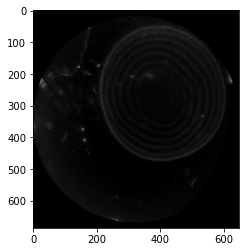

In [19]:
print_frame(get_frame(vid, 0), labels[700], pos_hat[700])

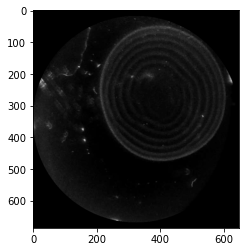

In [20]:
# write predictions and true value into video

size = (M, N)
# out = cv2.VideoWriter('../out/predictions.avi',cv2.VideoWriter_fourcc(*'DIVX') , 30, size)
out = cv2.VideoWriter('../out/predictions.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 50, size)
# cv2.VideoWriter_fourcc('M','J','P','G')
f0 = get_frame(vid, 0)
for t in range(1, N_FRAMES):
    _, f0 = vid.read()

    if t in labels:
        t1, t2 = int(labels[t][0]), int(labels[t][1])
        f0[t1-2:t1+2, t2-2:t2+2] = np.array([0, 255, 0])

    if t in pos_hat:
        e1, e2 = int(pos_hat[t][0]), int(pos_hat[t][1])
        f0[e1-2:e1+2, e2-2:e2+2] = np.array([0, 0, 255])

    out.write(f0)
out.release()

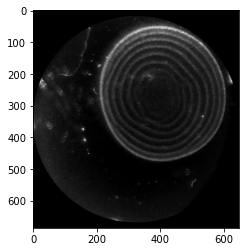

In [77]:
# video of naive subtraction

size = (M,N)

avg_window = 60
half_window = (avg_window - 1) // 2
kernel_size = (3,3)

out_name = '../out/no_bgnd_' + str(avg_window) +  'window.avi'
out = cv2.VideoWriter(out_name, cv2.VideoWriter_fourcc('M','J','P','G'), 50, size)

avg_window = 40
half_window = (avg_window - 1) // 2
kernel_size = (3,3)

# fill queue
q = []
q.append(get_frame(vid, 0))
for _ in range(avg_window-1):
    q.append(get_next_frame(vid))

mn = mean_frame(vid, 0, avg_window)
f0 = get_frame(vid, half_window)
for t in range(half_window, N_FRAMES - half_window - 1):
    right_frame = get_next_frame(vid)
    mn = (mn.astype(int) + (right_frame.astype(int) - q.pop(0).astype(int)) / avg_window).astype(np.uint8) # update mean
    res_f = cv2.blur(cv2.absdiff(mn, q[half_window]), kernel_size)
    res_f = cv2.merge((res_f,res_f,res_f))
    out.write(res_f)
    q.append(right_frame)

out.release()


(array([ 1.,  0.,  2.,  1.,  0.,  1.,  4.,  0.,  2.,  4.,  3.,  3.,  4.,
         3.,  2.,  1.,  3.,  1.,  2.,  5.,  3.,  0.,  6.,  7.,  5.,  7.,
         6.,  6.,  8.,  5.,  6.,  3., 11.,  4.,  4., 10., 11., 10., 14.,
         7., 10.,  6.,  0.,  9., 10.,  6.,  9.,  9.,  6.,  7., 11.,  9.,
         8., 11., 12.,  6., 17., 11., 21., 10., 11.,  7.,  9.,  0., 11.,
        13., 16., 10., 17.,  2., 17., 12., 17., 15., 10., 18., 13., 17.,
        12., 15., 18., 23., 14., 16., 11.,  0., 21., 22., 17., 10., 24.,
        21., 24., 20., 20., 23., 25., 24., 26., 25., 22., 26., 26., 20.,
        27., 12.,  0., 34., 31., 25., 21., 39., 25., 27., 19., 17., 23.,
        22., 28., 37., 34., 41., 26., 30., 25., 25., 24.,  0., 28., 32.,
        32., 24., 26., 20., 28., 22., 20., 24., 26., 21., 21., 15., 17.,
        15., 14., 19., 17., 16., 15.,  0., 12., 16., 10., 19., 16., 21.,
        15., 12., 11., 14., 11., 17., 12., 13.,  7., 14., 10.,  6., 11.,
         4.,  0.,  7.,  7.,  6.,  5.,  9.,  6., 10.

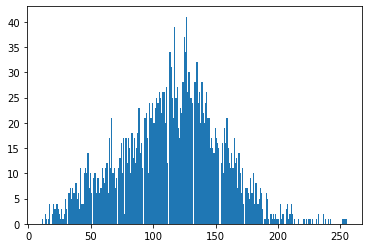

In [21]:
# show histogram of the worm
hh = []
vid.set(cv2.CAP_PROP_POS_FRAMES, 0)
for t in range(1, N_FRAMES):
    _, f0 = vid.read()
    if t in labels:
        t1, t2 = int(labels[t][0]), int(labels[t][1])
        hh.append(f0[t1, t2, 0])

plt.hist(hh, bins=256)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   7.,   5.,  11.,  17.,  33.,
         45.,  84., 118., 107., 120., 134., 138., 134., 108., 100.,  77.,
         72.,  66.,  52.,  43.,  37.,  37.,  28.,  24.,  29.,  30.,  19.,
         27.,  26.,  24.,  24.,  45.,  30.,  37.,  37.,  29.,  26.,  19.,
         21.,  21.,  19.,  19.,  28.,  12.,  22.,  27.,  27.,  35.,  25.,
         30.,  26.,  29.,  29.,  30.,  29.,  39.,  22.,  26.,  40.,  36.,
         31.,  33.,  27.,  24.,  31.,  16.,  17.,  19.,  15.,  18.,  15.,
         22.,  20.,  18.,  19.,  11.,  13.,   4.,   7.,   7.,  10.,   6.,
          3.,   2.,   2.,   3.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

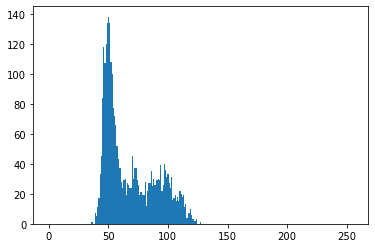

In [66]:
# show histogram of a particular pixel
# hh = np.zeros((N, M, 256))
hh = []
vid.set(cv2.CAP_PROP_POS_FRAMES, 0)
for t in range(1, N_FRAMES):
        _, f0 = vid.read()
        hh.append(f0[52,400,0])
        # for i in range(N):
        #         for j in range(M):
        #                 hh[i,j, f0] += 1
        # if t%100 == 0:
        #         print(t, "frames out of", N_FRAMES)

plt.hist(hh, bins=256, range=(0,255))

In [64]:
hh = np.zeros((N, M, 256))
MM = [[0]]
print(hh[MM].shape)
print(N,M)

(1, 1, 648, 256)
686 648


In [42]:
# background subtracktion using opencv background subtracktor MOG2

size = (M,N)
varThreshold = 16
nmix = 1
hist = 300

poshat = None

for nmix in [3]: # loops for tuning. At the moment, best solution is nmix=3, varThreshold=32, hist=300
    for varThreshold in [32]:
        bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=hist, varThreshold=varThreshold, detectShadows=False)
        bg_subtractor.setNMixtures(2)

        out_name = '../out/vid' + str(VID_NUM) + '_MOG2_th' + str(varThreshold) +  '_Nmix' + str(nmix) + '_hist' + str(hist) + '.avi'
        out = cv2.VideoWriter(out_name, cv2.VideoWriter_fourcc('M','J','P','G'), 50, size)

        vid.set(cv2.CAP_PROP_POS_FRAMES, 0)
        for t in range(N_FRAMES):
            _, frame = vid.read()

            # background subtractor
            res_f = bg_subtractor.apply(frame)

            # remove outside of petri dish. For each different video, it might need different parameters.
            res_f = remove_outside_petri(res_f, [N//2, M//2 + 0], 320, 320)

            #########################
            # image processing techniques

            # morphological operations on the binary image
            # res_f = cv2.dilate(res_f, np.ones((5,5), np.uint8))  # dilation to connect the componets of the worm
            # res_f = cv2.erode(res_f, np.ones((7,7), np.uint8))   # erosion to remove noise 
            # big closure (dilate and then erode) to connect all components of the norm without worrying about noise (already removed)
            res_f = cv2.morphologyEx(res_f, cv2.MORPH_CLOSE, np.ones((11,11), np.uint8))

            #########################

            # convert to 3 channel image and write
            res_f = cv2.merge((res_f,res_f,res_f))
            out.write(res_f)

            if t == 2000: # for debugging
                break

        out.release()
